---

<div class="alert alert-primary alert-info">

# $\delta$ hedging
    
- Black Scholes $\delta$ hedging
- Deep $\delta$ hedging

</div>

---

Cost of hedging.

$\sum_{t=0}^{T-1} \delta_t (S_{t+1} - S_{t})$

---

Transaction costs.

$\sum_{t=0}^{T} c_t (\delta_{t} - \delta_{t-1})$

$\delta_{-1} = \delta_{T} := 0$

---

Additional cashflow for the self-financing portfolio. $p_{0}$

---

Liability. $Z$

---

Terminal portfolio value at $T$

$\text{PL}_{T} ( Z, p_{0}, \{ \delta_{t} \}_{t=0}^{T-1}) := -Z + p_{0} + \sum_{t=0}^{T-1} \delta_t (S_{t+1} - S_{t}) - \sum_{t=0}^{T} c_t (\delta_{t} - \delta_{t-1})$

---

Risk measures. $f_{\text{risk}}(\text{PL}_{T} ( Z, p_{0}, \{ \delta_{t} \}_{t=0}^{T-1}))$

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
np.random.seed(1234)

plt.style.use('seaborn-dark-palette')

import warnings
warnings.filterwarnings('ignore')

---

In [3]:
def generate_log_geometric_brownian_motion(S_0, T, mu, sigma, num_timesteps, num_scenarios):
    
    dt = T / num_timesteps
    
    num_timesteps += 1
    
    paths = np.random.normal(loc=0.0, scale=1.0, size=(num_timesteps, num_scenarios))
    
    paths[0, :] = S_0
    
    for t_i in range(1, num_timesteps):
        paths[t_i, :] = paths[t_i - 1, :] * np.exp((mu - 0.5 * sigma**2) * dt +
                                            sigma * np.sqrt(dt) * paths[t_i, :])

    return paths

In [4]:
S_0 = 100.0
K = 100.0
mu = 0.0
sigma = 0.2
T = 1.0
num_timesteps = 252
num_scenarios = 10**4

paths = generate_log_geometric_brownian_motion(S_0, T, mu, sigma, num_timesteps, num_scenarios)

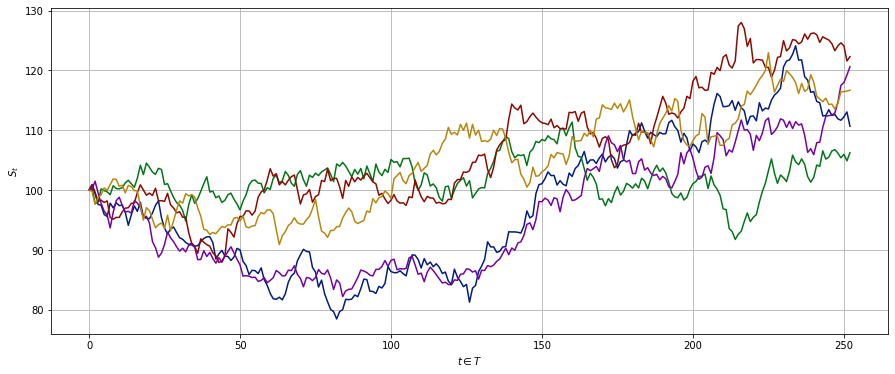

In [5]:
plt.figure(figsize=(15, 6))
plt.xlabel('$t \in T$')
plt.ylabel('$S_t$')
plt.grid()
plt.plot(np.arange(num_timesteps+1), paths[:, 0:5]);

---

### Black Scholes call option price and delta

In [6]:
def blackscholes_price(S, r, sigma, K, t, T):
    dt = T-t
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * dt) / (sigma * np.sqrt(dt))
    d2 = d1 - sigma * np.sqrt(dt)
    return S * stats.norm().cdf(d1) - K * np.exp(-r * dt) * stats.norm().cdf(d2)

def blackscholes_call_delta(S, r, sigma, K, t, T):
    dt = T-t
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * dt) / (sigma * np.sqrt(dt))
    return stats.norm().cdf(d1)

---

### Black Scholes $\delta$ hedging strategy

In [7]:
def blackscholes_delta_hedging_strategy(S_0, K, r, sigma, T, paths, transaction_costs, additional_cashflow=0.0):
    
    assert len(transaction_costs) == paths.shape[0]
    
    dt = T/(paths.shape[0]-1)
    print('dt: ', dt)
    
    timegrid = np.full(paths.shape[0], fill_value=dt)
    timegrid[0] = 0.0
    timegrid = np.cumsum(timegrid)
    print('\nTimegrid: ', timegrid.shape)
    print(timegrid)
    
    deltas = np.zeros((paths.shape[0], paths.shape[1]))
    
    for i in range(timegrid.shape[0]):
        deltas[i,:] = blackscholes_call_delta(paths[i,:], r, sigma, K, timegrid[i], T)
    
    dS = np.diff(paths, axis=0)
    
    pnl_hedge_only = np.sum(deltas[:-1] * dS, axis=0)
    
    dDeltas = np.diff(deltas, axis=0)
    sum_transaction_costs = np.sum(transaction_costs[1:] @ dDeltas)
    
    option_payoffs = np.maximum(paths[-1,:] - K, 0)
    
    option_price = blackscholes_price(S_0, r, sigma, K, 0, T)
    print('\nBlack Scholes price: ', option_price)
    
    portfolio_pnl = -option_payoffs + additional_cashflow + pnl_hedge_only + option_price - sum_transaction_costs
    
    return portfolio_pnl, deltas

In [8]:
portfolio_pnl, deltas = blackscholes_delta_hedging_strategy(S_0, K, mu, sigma, T, paths, np.zeros(paths.shape[0]))

dt:  0.003968253968253968

Timegrid:  (253,)
[0.         0.00396825 0.00793651 0.01190476 0.01587302 0.01984127
 0.02380952 0.02777778 0.03174603 0.03571429 0.03968254 0.04365079
 0.04761905 0.0515873  0.05555556 0.05952381 0.06349206 0.06746032
 0.07142857 0.07539683 0.07936508 0.08333333 0.08730159 0.09126984
 0.0952381  0.09920635 0.1031746  0.10714286 0.11111111 0.11507937
 0.11904762 0.12301587 0.12698413 0.13095238 0.13492063 0.13888889
 0.14285714 0.1468254  0.15079365 0.1547619  0.15873016 0.16269841
 0.16666667 0.17063492 0.17460317 0.17857143 0.18253968 0.18650794
 0.19047619 0.19444444 0.1984127  0.20238095 0.20634921 0.21031746
 0.21428571 0.21825397 0.22222222 0.22619048 0.23015873 0.23412698
 0.23809524 0.24206349 0.24603175 0.25       0.25396825 0.25793651
 0.26190476 0.26587302 0.26984127 0.27380952 0.27777778 0.28174603
 0.28571429 0.28968254 0.29365079 0.29761905 0.3015873  0.30555556
 0.30952381 0.31349206 0.31746032 0.32142857 0.32539683 0.32936508
 0.33333333 0.337


Mean hedging PnL: -0.005336550687285073


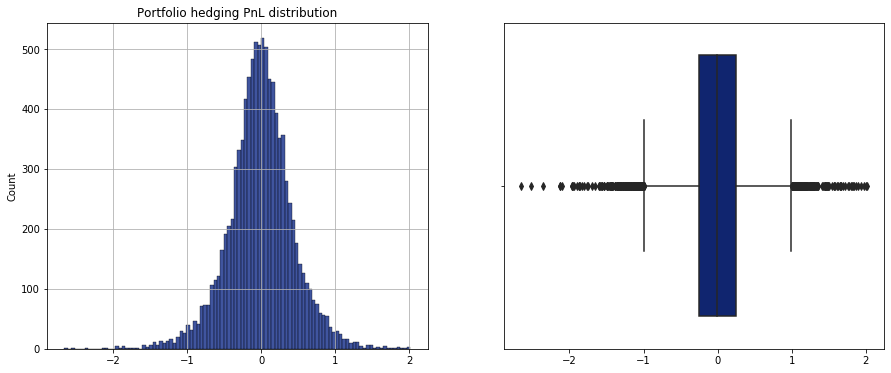

In [9]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title('Portfolio hedging PnL distribution')
sns.histplot(portfolio_pnl);
plt.grid()

plt.subplot(1, 2, 2)
sns.boxplot(portfolio_pnl);

print('\nMean hedging PnL:', np.mean(portfolio_pnl))

---

### Risk measures

- VaR
- CVaR

In [10]:
def value_at_risk(alpha: float, portfolio_pnl: float) -> float:
    return -np.sort(portfolio_pnl)[int((1-alpha)*portfolio_pnl.shape[0])-1]

def conditional_value_at_risk(alpha: float, portfolio_pnl: float) -> float:
    return -np.mean(np.sort(portfolio_pnl)[:int((1-alpha)*portfolio_pnl.shape[0])])

#### $\alpha=\{99\%, 95\%\}$

In [11]:
alpha = [0.99, 0.95]

for i, a in enumerate(alpha):
    print('\n{}% VaR: {}'.format(int(alpha[i]*100), value_at_risk(alpha[i], portfolio_pnl)))
    print('{}% CVaR: {}'.format(int(alpha[i]*100), conditional_value_at_risk(alpha[i], portfolio_pnl)))


99% VaR: 1.1992997219207773
99% CVaR: 1.4846195956954975

95% VaR: 0.7285015002536319
95% CVaR: 1.016457632489989


---

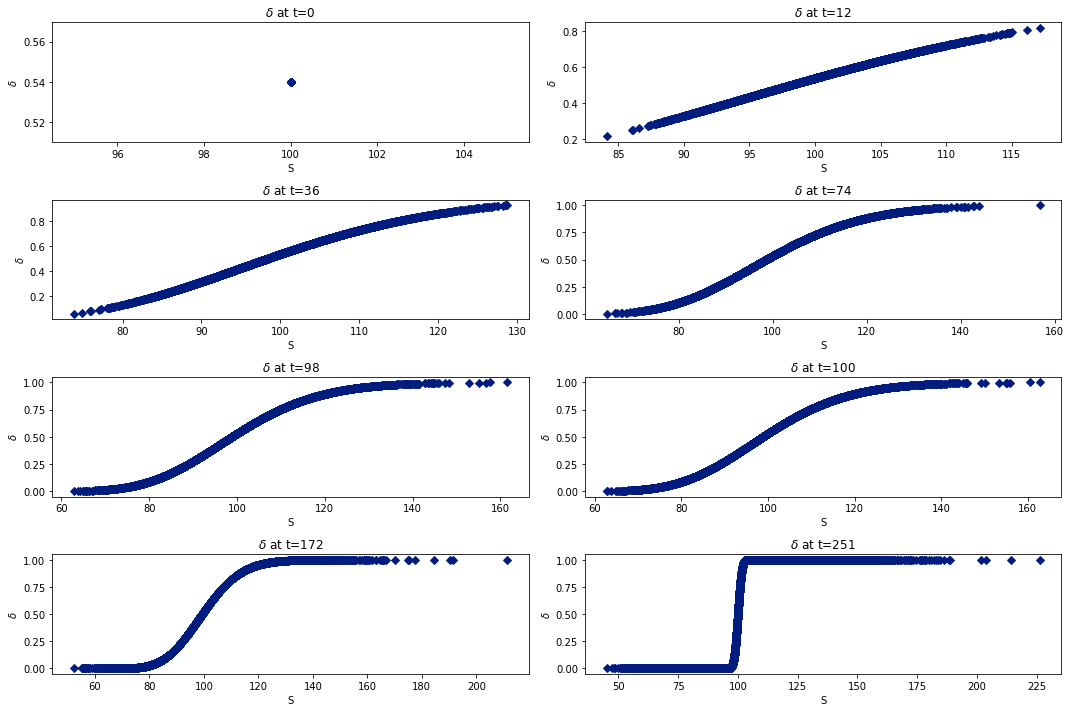

In [12]:
sampled_timesteps = [0, 12, 36, 74, 98, 100, 172, 251]

fig = plt.figure(figsize=(15,10))

for i, t in enumerate(sampled_timesteps):
    plt.subplot(4, 2, i+1)
    plt.plot(paths[t, :], deltas[t, :], linestyle='', marker='D')
    plt.title('$\delta$ at t=%i' % t)
    plt.xlabel('S')
    plt.ylabel('$\delta$')
    
plt.tight_layout()

---

## Deep $\delta$ hedging

In [13]:
import tensorflow as tf
import tensorflow.keras.backend as tfbK

from tensorflow.keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import initializers

In [14]:
m = 1
d = 3
n = 8

# architecture is the same for all networks
layers = []

for j in range(num_timesteps):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))

        layers = layers + [layer]

In [15]:
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedge_eval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price] + [hedge] + [hedge_eval] + [premium]
output_helper = []

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(num_timesteps):
    strategy = price
    strategy_eval = hedge_eval
    for k in range(d):
        strategy = layers[k+(j)*d](strategy)
        strategy_eval = layers[k+(j)*d](strategy_eval)
    incr = Input(shape=(m,))
    logprice = Lambda(lambda x : tfbK.log(x))(price)
    logprice = Add()([logprice, incr])
    price_new = Lambda(lambda x : tfbK.exp(x))(logprice)
    price_incr = Subtract()([price_new, price])
    hedge_new = Multiply()([strategy, price_incr])
    hedge = Add()([hedge, hedge_new])
    inputs = inputs + [incr]
    output_helper = output_helper + [strategy_eval]
    price = price_new

payoff= Lambda(lambda x : 0.5*(tfbK.abs(x-(K/100.0))+x-(K/100.0)))(price) 
outputs = Subtract()([payoff, hedge]) 
outputs = Subtract()([outputs, premium])
outputs= [outputs] + output_helper + [premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

def custom_loss(y_true,y_pred):
    z = y_pred[:,0] - y_true[:,0]
    z = tfbK.mean(tfbK.square(z))
    return z

model_hedge_strat.compile(optimizer='adam', loss=custom_loss)

In [16]:
Ktrain = 10**5

price_bs = blackscholes_price(S_0, mu, sigma, K, 0, T)

dt = T / num_timesteps

xtrain = ([(S_0/100.0) * np.ones((Ktrain, m))] +
          [np.zeros((Ktrain, m))]+
          [np.ones((Ktrain, m))] +
          [price_bs * np.ones((Ktrain, m))]+
          [np.random.normal((mu-(0.5*sigma**2))*dt, sigma*np.sqrt(dt), (Ktrain, m)) for i in range(num_timesteps)])

ytrain = np.zeros((Ktrain, num_timesteps)) # np.ones((Ktrain, num_timesteps))

In [17]:
model_hedge_strat.fit(x=xtrain, y=ytrain, epochs=15, verbose=True)

Epoch 1/15
3125/3125 [==============================] - 202s 42ms/step - loss: 20.5033
Epoch 2/15
3125/3125 [==============================] - 138s 44ms/step - loss: 0.0047
Epoch 3/15
3125/3125 [==============================] - 128s 41ms/step - loss: 0.0026
Epoch 4/15
3125/3125 [==============================] - 125s 40ms/step - loss: 9.3688e-04
Epoch 5/15
3125/3125 [==============================] - 137s 44ms/step - loss: 4.6941e-043s - loss: 4 - ETA: 2s - loss: 4.6987e
Epoch 6/15
3125/3125 [==============================] - 135s 43ms/step - loss: 3.7917e-04
Epoch 7/15
3125/3125 [==============================] - 135s 43ms/step - loss: 3.1980e-04
Epoch 8/15
3125/3125 [==============================] - 141s 45ms/step - loss: 2.6511e-04
Epoch 9/15
3125/3125 [==============================] - 150s 48ms/step - loss: 2.2065e-04
Epoch 10/15
3125/3125 [==============================] - 154s 49ms/step - loss: 1.7470e-04
Epoch 11/15
3125/3125 [==============================] - 186s 60ms/step 

In [18]:
Ktest = 10**4

xtest = ([(S_0/100.0) * np.ones((Ktest, m))] +
          [np.zeros((Ktest, m))] +
          [np.linspace(0.5, 1.5, Ktest)] +
          [price_bs * np.ones((Ktest, m))] +
          [np.random.normal((mu-(0.5*sigma**2))*dt, sigma*np.sqrt(dt), (Ktest, m)) for i in range(num_timesteps)])

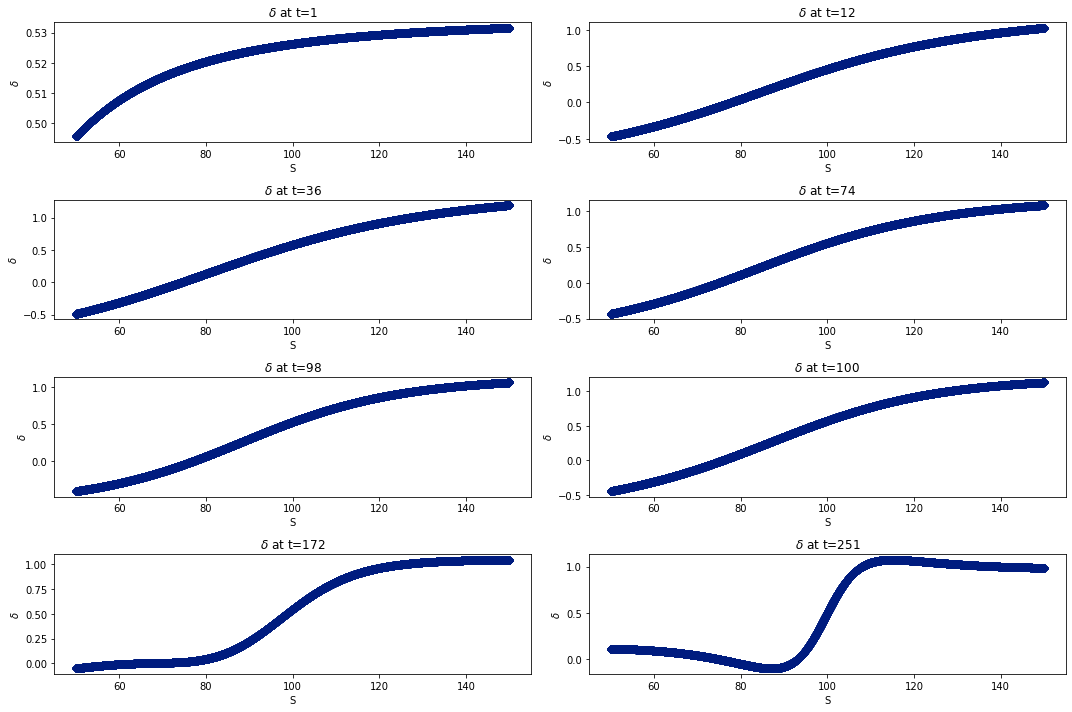

In [19]:
predictions = model_hedge_strat.predict(xtest)

s = np.linspace(50, 150, Ktest)

sampled_timesteps = [1, 12, 36, 74, 98, 100, 172, 251]

fig = plt.figure(figsize=(15,10))

for i, t in enumerate(sampled_timesteps):
    plt.subplot(4, 2, i+1)
    plt.plot(s, predictions[:, t], linestyle='', marker='D')
    plt.title('$\delta$ at t=%i' % t)
    plt.xlabel('S')
    plt.ylabel('$\delta$')
    
plt.tight_layout()

---

https://arxiv.org/abs/1802.03042